### Index

+ **목표**: 고관여 고객 추출 (이후, 제품 matching)
+ **대상** : 다이렉트 체널에서 최근 1년간 구매고객
+ **적용방법**
  + [x] 1.RFM 내용 기반 자료 추출
  + [x] 2.tier 분류 : k-means 적용
  + [x] 3.개인별 targetting : 추천 시스템(SVD)적용
  + [x] 4.결과 정리
 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
%matplotlib inline

path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)                               # 한글폰트 설정(전역)

### 1.RFM 내용 기반 자료 추출

In [2]:
# data 불러오기
df_RFM = pd.read_excel('./data/200617_고객성향분석_direct(임직원제외).xlsx','Sheet1')

In [3]:
df_RFM.head(2)

,MEMBER_NO,FREQUENCY,MONETORY,RECENCY
0,383331,978,47065900,155
1,384549,594,20113500,164


In [4]:
df_RFM = df_RFM.drop(['MEMBER_NO'],axis=1)

In [5]:
df_RFM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178618 entries, 0 to 178617
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   FREQUENCY  178618 non-null  int64
 1   MONETORY   178618 non-null  int64
 2   RECENCY    178618 non-null  int64
dtypes: int64(3)
memory usage: 4.1 MB


In [91]:
# outlier 제거
# df1.loc[(df1.연령 > df1['연령'].quantile(0.999) ),'연령']= 0
# df1.loc[(df1.연령 < df1['연령'].quantile(0.001) ),'연령']= 0

In [92]:
df_RFM.tail(2)

,FREQUENCY,MONETORY,RECENCY
178616,1,17800,1
178617,1,79600,0


In [7]:
df_RFM.describe().T

,count,mean,std,min,25%,50%,75%,max
FREQUENCY,178618.0,1.182703,4.144217,1.0,1.0,1.0,1.0,978.0
MONETORY,178618.0,11855.009081,171500.125150,102.0,4000.0,4000.0,4000.0,47065900.0
RECENCY,178618.0,67.914040,73.981814,0.0,40.0,41.0,43.0,365.0


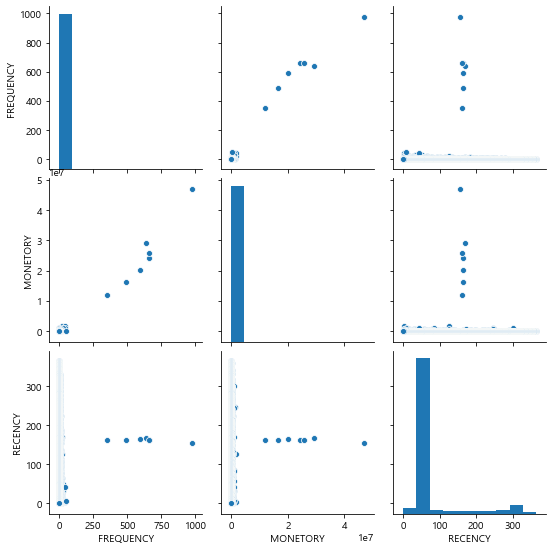

In [8]:
sns.pairplot(df_RFM)
plt.show()

### 2.tier 분류 : k-means 적용

In [6]:
from sklearn.cluster import KMeans

# data 준비
data = df_RFM

# model 생성 
model = KMeans(n_clusters=10, random_state=0)

# 원자료 + prediction
feature = data[ ['FREQUENCY', 'MONETORY', 'RECENCY'] ]
predict = pd.DataFrame(model.fit_predict(feature))
predict.columns=['predict']
r = pd.concat([feature,predict],axis=1)

In [7]:
r['predict']=r['predict'].astype('str')

In [8]:
r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178618 entries, 0 to 178617
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   FREQUENCY  178618 non-null  int64 
 1   MONETORY   178618 non-null  int64 
 2   RECENCY    178618 non-null  int64 
 3   predict    178618 non-null  object
dtypes: int64(3), object(1)
memory usage: 5.5+ MB


In [19]:
df_RFM_result1 = r.groupby('predict')['FREQUENCY'].count().reset_index()
df_RFM_result1 = df_RFM_result1.rename(columns = {'FREQUENCY' : 'COUNT'})

In [20]:
df_RFM_result1

,FREQUENCY,MONETORY,RECENCY,predict
0,978,47065900,155,3
1,594,20113500,164,2
2,659,24317800,163,6
3,351,12059900,162,4
4,488,16379700,163,9


In [110]:
r.describe().T

,count,mean,std,min,25%,50%,75%,max
FREQUENCY,178618.0,1.182703,4.144217,1.0,1.0,1.0,1.0,978.0
MONETORY,178618.0,11855.009081,171500.125150,102.0,4000.0,4000.0,4000.0,47065900.0
RECENCY,178618.0,67.914040,73.981814,0.0,40.0,41.0,43.0,365.0


In [111]:
# Excel 저장
name = '200617_고객성향분석_direct_c2.xlsx'
r.to_excel(name, sheet_name= 'Sheet1' )

### 3.추천 시스템 적용 : TruncatedSVD

In [65]:
# data 불러오기
df_SKU = pd.read_excel('./data/200617_고객성향분석_direct_step2.xlsx','Sheet1')

In [66]:
df_SKU.head(2)

,UNFY_MMB_NO,CATEGORY_CODE,PRODUCT_CODE,PRODUCT_NAME,PRODUCT_PRICE,PRODUCT_QTY,group
0,5369763,C24004,P00141,★베스트셀러 세트★,11000,1,8
1,5369763,C21004,P00039,상하목장우유 저지방 750ml,4650,1,8


In [67]:
df_table = pd.crosstab(df_SKU["UNFY_MMB_NO"], df_SKU["CATEGORY_CODE"],  df_SKU["PRODUCT_QTY"], aggfunc='sum').fillna(0).sort_values(by ='UNFY_MMB_NO', ascending = True)

In [68]:
df_table.head(2)

CATEGORY_CODE,C21001,C21002,C21003,C21004,C21005,C21006,C22001,C22002,C22003,C22004,...,C24003,C24004,C25001,C25002,C25003,C26001,C27001,C28001,C29001,D15004
UNFY_MMB_NO,,,,,,,,,,,,,,,,,,,,,
444447,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2544572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0


In [69]:
df_SKU_v1 = df_SKU.drop(['CATEGORY_CODE', 'PRODUCT_NAME', 'PRODUCT_PRICE', 'group'],axis=1)

In [70]:
df_SKU_v1.head(2)

,UNFY_MMB_NO,PRODUCT_CODE,PRODUCT_QTY
0,5369763,P00141,1
1,5369763,P00039,1


In [71]:
df_indices.head(2)

,userId,UNFY_MMB_NO,RECOMMEND
0,0,444447,"[[C22001, C23002, C21001]]"
1,1,2544572,"[[D15004, C27001, C22002]]"


In [72]:
df_array_user = df_table.values
df_array_category = df_table.T.values

from sklearn.decomposition import TruncatedSVD

# 차원축소
SVD = TruncatedSVD(n_components=12)
SVD_matrix_user = SVD.fit_transform(df_array_user)
SVD_matrix_category = SVD.fit_transform(df_array_category)
# SVD_matrix.shape

# 상관관계
corr_SVD_user = np.corrcoef(SVD_matrix_user)
corr_SVD_category = np.corrcoef(SVD_matrix_category)
# corr_SVD_user.shape

In [73]:
#자료 확인
corr_SVD_user.shape, corr_SVD_category.shape

((14727, 14727), (29, 29))

In [74]:
df_svd_preds = pd.DataFrame(corr_SVD_user)

In [75]:
indices = pd.Series(df_table.index, index=df_svd_preds.index).drop_duplicates()
df_indices = pd.DataFrame(indices).reset_index()
df_indices = df_indices.rename(columns = {'index' : 'userId'})

In [76]:
target = list(df_indices['userId'])

# df_indices_result = df_indices.copy()
# df_indices_result['PRODUCT_RECOMMDATIONS'] = 

In [77]:
%%time 

df_indices_result =[]

for i in range(0, len(target)):
    # 개인 선택
    user_row_number = i

    # 선택한 개인의 회원번호
    userId = indices.loc[user_row_number]

    # 유사 인원에 대한 정렬
    sorted_user_predictions = df_svd_preds[user_row_number].sort_values(ascending = False)
    sorted_user_predictions = pd.DataFrame(sorted_user_predictions).reset_index()
    sorted_user_predictions = sorted_user_predictions.rename(columns = {'index' : 'userId', 1 : 'Predictions'})

    #구매 내용에서, 해당고객 추출(ex. 0-> 5369763)
    user_data = df_SKU_v1[df_SKU_v1.UNFY_MMB_NO == userId]
    user_history = pd.DataFrame(user_data.groupby(['UNFY_MMB_NO', 'PRODUCT_CODE'])['PRODUCT_QTY'].sum().reset_index())

    # 구매한 제품은 제외
    recommandations = df_SKU_v1[~df_SKU_v1['PRODUCT_CODE'].isin(user_history['PRODUCT_CODE'])]

    # 제품과 유사도 내용을 합친다
    recommandations = recommandations.merge(df_indices, on ='UNFY_MMB_NO')
    recommandations = recommandations.merge(sorted_user_predictions, on ='userId').rename(columns = {'index' : 'userId', i : 'Predictions'})
    recommandations = recommandations.sort_values(by ='Predictions', ascending = False)

    #제품별 중복 제거
    recommandations = recommandations[['PRODUCT_CODE']].drop_duplicates(['PRODUCT_CODE'])[:3]
    recommandations = recommandations.T.values

    #3개 제품만 선택
#     recommandations = recommandations[['CATEGORY_CODE']].drop_duplicates(['CATEGORY_CODE'])[:3]
    df_indices_result.append(recommandations)

Wall time: 13min 32s


In [78]:
df_indices['RECOMMEND'] =''
for i in range(0, len(df_indices_result)):
    df_indices['RECOMMEND'][i] = df_indices_result[i]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [79]:
df_indices.tail()

,userId,UNFY_MMB_NO,RECOMMEND
14722,14722,5942429,"[[P00319, P00171, P00057]]"
14723,14723,5944125,"[[P00336, P00357, P00337]]"
14724,14724,5944352,"[[P00650, P00656, P00871]]"
14725,14725,5944361,"[[P00360, P00029, P00582]]"
14726,14726,5945466,"[[P00357, P00319, P00036]]"


In [80]:
# Excel 저장
name = '200622_고객성향분석_direct_c3.xlsx'
df_indices.to_excel(name, sheet_name= 'Sheet1' )

In [34]:
# 개인 선택
user_row_number = i
    
# 선택한 개인의 회원번호
userId = indices.loc[user_row_number]

# 유사 인원에 대한 정렬
sorted_user_predictions = df_svd_preds[user_row_number].sort_values(ascending = False)
sorted_user_predictions = pd.DataFrame(sorted_user_predictions).reset_index()
sorted_user_predictions = sorted_user_predictions.rename(columns = {'index' : 'userId', 1 : 'Predictions'})

#구매 내용에서, 해당고객 추출(ex. 0-> 5369763)
user_data = df_SKU_v1[df_SKU_v1.UNFY_MMB_NO == userId]
user_history = pd.DataFrame(user_data.groupby(['UNFY_MMB_NO', 'CATEGORY_CODE'])['PRODUCT_QTY'].sum().reset_index())
    
# 구매한 제품은 제외
recommandations = df_SKU_v1[~df_SKU_v1['CATEGORY_CODE'].isin(user_history['CATEGORY_CODE'])]

# 제품과 유사도 내용을 합친다
recommandations = recommandations.merge(df_indices, on ='UNFY_MMB_NO')
recommandations = recommandations.merge(sorted_user_predictions, on ='userId').rename(columns = {'index' : 'userId', i : 'Predictions'})
recommandations = recommandations.sort_values(by ='Predictions', ascending = False)

#제품별 중복 제거
recommandations = recommandations[['CATEGORY_CODE','Predictions']].drop_duplicates(['CATEGORY_CODE'])[:3]
    
#3개 제품만 선택
recommandations = recommandations[['CATEGORY_CODE','Predictions']].drop_duplicates(['CATEGORY_CODE'])[:3]


NameError: name 'i' is not defined

In [454]:
recommandations

,CATEGORY_CODE,Predictions
5064,C22001,0.993765
30380,C22003,0.982897
30379,C21004,0.982897


In [81]:
# df_indices_result

In [451]:
%%time 

df_indices_result =[]

for i in range(0, len(target)):
    # 개인 선택
    user_row_number = i
    
    # 선택한 개인의 회원번호
    userId = indices.loc[user_row_number]

    # 유사 인원에 대한 정렬
    sorted_user_predictions = ''
    sorted_user_predictions = df_svd_preds[user_row_number].sort_values(ascending = False)
    sorted_user_predictions = pd.DataFrame(sorted_user_predictions).reset_index()
    sorted_user_predictions = sorted_user_predictions.rename(columns = {'index' : 'userId', 1 : 'Predictions'})

    #구매 내용에서, 해당고객 추출(ex. 0-> 5369763)
    user_data = df_SKU_v1[df_SKU_v1.UNFY_MMB_NO == userId]
    user_history = pd.DataFrame(user_data.groupby(['UNFY_MMB_NO', 'PRODUCT_CODE'])['PRODUCT_QTY'].sum().reset_index())
    
    # 구매한 제품은 제외
    recommandations = df_SKU_v1[~df_SKU_v1['PRODUCT_CODE'].isin(user_history['PRODUCT_CODE'])]

    # 제품과 유사도 내용을 합친다
    recommandations = recommandations.merge(df_indices, on ='UNFY_MMB_NO')
    recommandations = recommandations.merge(sorted_user_predictions, on ='userId').rename(columns = {'index' : 'userId', i : 'Predictions'})
    recommandations = recommandations.sort_values(by ='Predictions', ascending = False)

    #제품별 중복 제거
    recommandations = recommandations[['PRODUCT_CODE','Predictions']].drop_duplicates(['PRODUCT_CODE'])[:3]
    
    #3개 제품만 선택
    recommandations = recommandations[['PRODUCT_CODE','Predictions']].drop_duplicates(['PRODUCT_CODE'])[:3]
    df_indices_result.append( list(recommandations['PRODUCT_CODE']) )
    

KeyError: 'PRODUCT_CODE'

In [411]:
recommandations

,PRODUCT_CODE,Predictions
37344,P00533,1.0
28433,P00430,1.0
30946,P00619,1.0


40432    P00453
39382    P00885
39381    P00397
Name: PRODUCT_CODE, dtype: object

In [412]:
# Excel 저장
name = '200619_고객성향분석_direct_c3.xlsx'
df_indices_result.to_excel(name, sheet_name= 'Sheet1' )